In [1]:
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F

PATH = "data_test/"


/home/guillaume/anaconda3/envs/semproj/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# useful for normalization
dataset_mean = np.load("dataset_mean.npy")
dataset_std = np.load("dataset_std.npy")

# Neural Net

## Dataloader

In [3]:
# Define the dataset class
class CustomDataset(Dataset):
    def __init__(self, data_folder, dataset_mean, dataset_std):
        self.dataset = []
        self.labels = []
        label_dict = {"come":0,"lie down":1,"sit":2,"stay":3}
        
        for folder in os.listdir(data_folder):
            for file in os.listdir(data_folder + folder):
                data = np.load(os.path.join(data_folder, folder, file))
                data = np.nan_to_num(data)
                data = np.clip(data, -10, 10)
                # normalize data
                data[:,:,0] = (data[:,:,0] - dataset_mean[0])/dataset_std[0]
                data[:,:,1] = (data[:,:,1] - dataset_mean[1])/dataset_std[1]
                data[:,:,2] = (data[:,:,2] - dataset_mean[2])/dataset_std[2]
                self.dataset.append(data)
                self.labels.append(label_dict[folder])

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        data = self.dataset[index]
        data = np.transpose(data, (2, 0, 1))
        label = self.labels[index]

        return torch.tensor(data).float(), torch.tensor(label)


## Model

In [4]:
class ConvNet(nn.Module):
    def __init__(self, n_input_channels=3, n_output=4):
        super().__init__()
    
        # input = 75x20x3
        self.conv1 = nn.Conv2d(n_input_channels, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        
        # input = 37x10x32
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        # input = 18x5x64
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        # input = 9x2x128
        self.fc1 = nn.Linear(128*9*2, 1024)
        self.fc2 = nn.Linear(1024, n_output)

    
    def forward(self, x):
        
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2) #maxpool of kernel size 2 to reduce the size of the images by a factor 2
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 128*9*2) #flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x
    
    def predict(self, x):
        logits = self.forward(x)
        return F.softmax(logits)

In [5]:
CHECKPOINT = "trained_model.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = ConvNet().to(device)
model.load_state_dict(torch.load(CHECKPOINT))
model.eval()

cuda


ConvNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=2304, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=4, bias=True)
)

In [6]:
test_loader = DataLoader(CustomDataset(PATH, dataset_mean, dataset_std), batch_size=1, shuffle=False)

In [7]:
# Evaluation
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    gt = []
    pred = []
    for inputs , labels in test_loader:
        # Move data to the device
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs)

        # Get predicted labels
        y_pred = outputs.argmax(dim = -1)

        gt.extend(labels.tolist())
        pred.extend(y_pred.tolist())

        # Update total and correct predictions
        total += labels.size(0)
        correct += (y_pred == labels).sum().item()

    # Print accuracy
    print('Test Accuracy: {:.2f}%'.format(100 * correct / total))

Test Accuracy: 77.31%


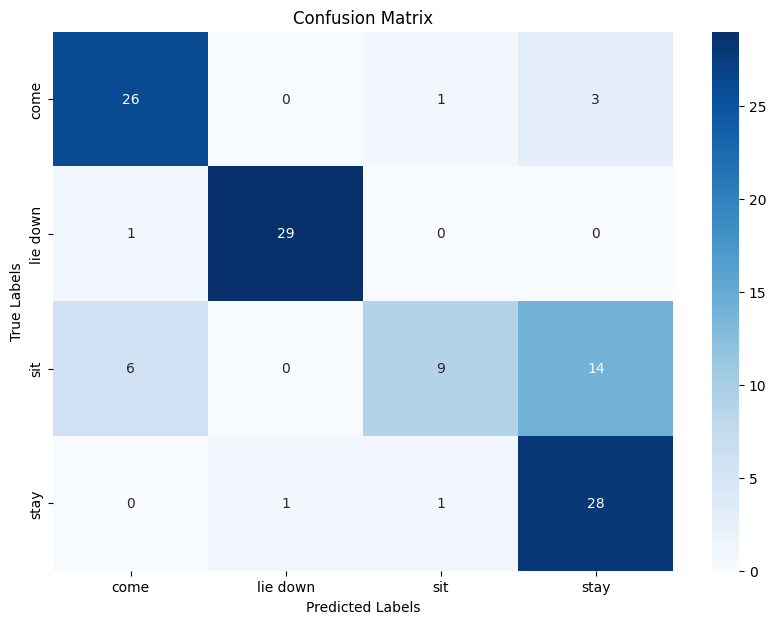

In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

label_dict = {"come":0,"lie down":1,"sit":2,"stay":3}

def plot_confusion_matrix(true_labels, predicted_labels, classes):
    cm = confusion_matrix(true_labels, predicted_labels)
    cm_df = pd.DataFrame(cm, index=classes, columns=classes)

    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_df, annot=True, cmap="Blues", fmt="d")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()


plot_confusion_matrix(gt, pred, list(label_dict.keys()))